In [72]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import math
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

In [2]:
signals = pd.read_csv("data/train/wind-farm-1-signals-training.csv", sep=";")
signals = signals[["Turbine_ID", "Timestamp", "Grd_Prod_Pwr_Avg", "Amb_WindSpeed_Avg", "Amb_Temp_Avg", "Nac_Temp_Avg", "Rtr_RPM_Avg", "Gear_Bear_Temp_Avg", "Gen_RPM_Avg", "Gen_Bear2_Temp_Avg", "Gen_Bear_Temp_Avg"]]
signals["Timestamp_Datetime"] = pd.to_datetime(signals.Timestamp)
signals.Timestamp_Datetime = signals.Timestamp_Datetime.apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second))
signals_T01 = signals.loc[signals.Turbine_ID == "T01"]
signals_T06 = signals.loc[signals.Turbine_ID == "T06"]
signals_T07 = signals.loc[signals.Turbine_ID == "T07"]
signals_T09 = signals.loc[signals.Turbine_ID == "T09"]
signals_T11 = signals.loc[signals.Turbine_ID == "T11"]

failures = pd.read_csv("data/train/wind-farm-1-failures-training.csv", sep=';')
failures.Timestamp = pd.to_datetime(failures.Timestamp)
failures.Timestamp = failures.Timestamp.apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour, 10 * math.floor(dt.minute / 10), dt.second))

# Detekcja starzenia się części
W oparciu o regresję modelującą zależność wytwarzanej mocy przy konkretnym wietrze.

In [42]:
windframe = signals_T01.loc[(5.0 <= signals_T01.Amb_WindSpeed_Avg) & (signals_T01.Amb_WindSpeed_Avg <= 5.5), :]
windframe["Time"] = windframe.Timestamp_Datetime.dt.month + 12 * (windframe.Timestamp_Datetime.dt.year - min(windframe.Timestamp_Datetime.dt.year))

<ipython-input-42-d5d8ea8d828e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  windframe["Time"] = windframe.Timestamp_Datetime.dt.month + 12 * (windframe.Timestamp_Datetime.dt.year - min(windframe.Timestamp_Datetime.dt.year))


In [43]:
windframe.columns

Index(['Turbine_ID', 'Timestamp', 'Grd_Prod_Pwr_Avg', 'Amb_WindSpeed_Avg',
       'Amb_Temp_Avg', 'Nac_Temp_Avg', 'Rtr_RPM_Avg', 'Gear_Bear_Temp_Avg',
       'Gen_RPM_Avg', 'Gen_Bear2_Temp_Avg', 'Gen_Bear_Temp_Avg',
       'Timestamp_Datetime', 'Time'],
      dtype='object')

### Badanie temperatury przy ustalonym produkowanym prądzie
-------
Na poniższym wykresie widać, że im dłużej używana jest turbina, tym wyższa temperatura przekładni przy tej samej produkcji prądu dla określonego wiartu (od 5.0 do 5.5 m/s).

<AxesSubplot:xlabel='Gear_Bear_Temp_Avg', ylabel='Grd_Prod_Pwr_Avg'>

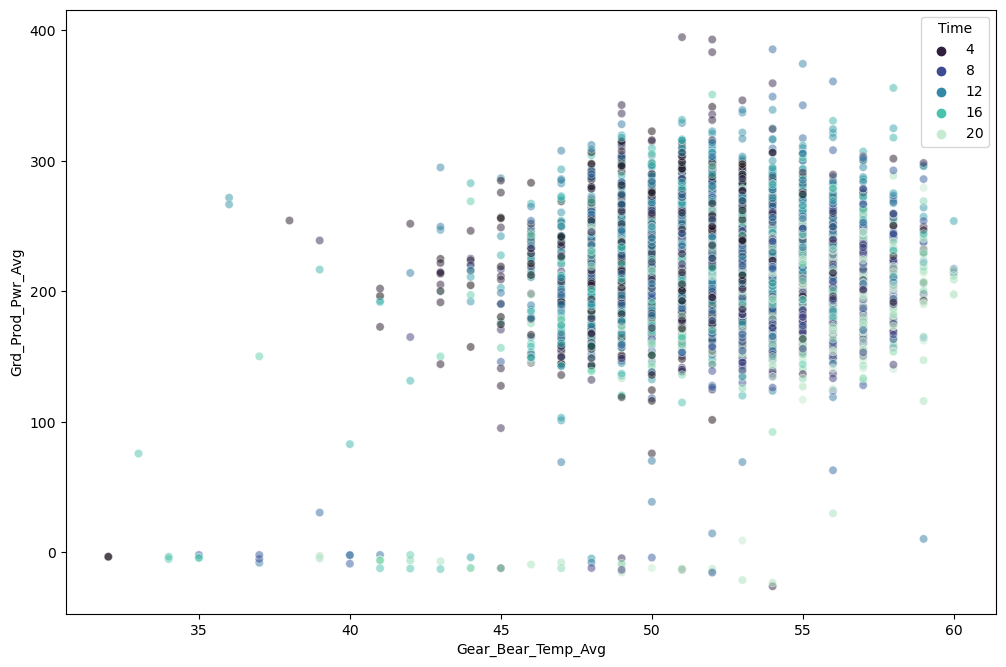

In [70]:
sns.scatterplot(data=windframe.sample(frac=1), x="Gear_Bear_Temp_Avg", y="Grd_Prod_Pwr_Avg", hue="Time", alpha=0.5, palette="mako")

Podobna sytuacja ma miejsce na drugim zestawie trybów w generatorze (ale nie w pierwszym).

<AxesSubplot:xlabel='Gen_Bear2_Temp_Avg', ylabel='Grd_Prod_Pwr_Avg'>

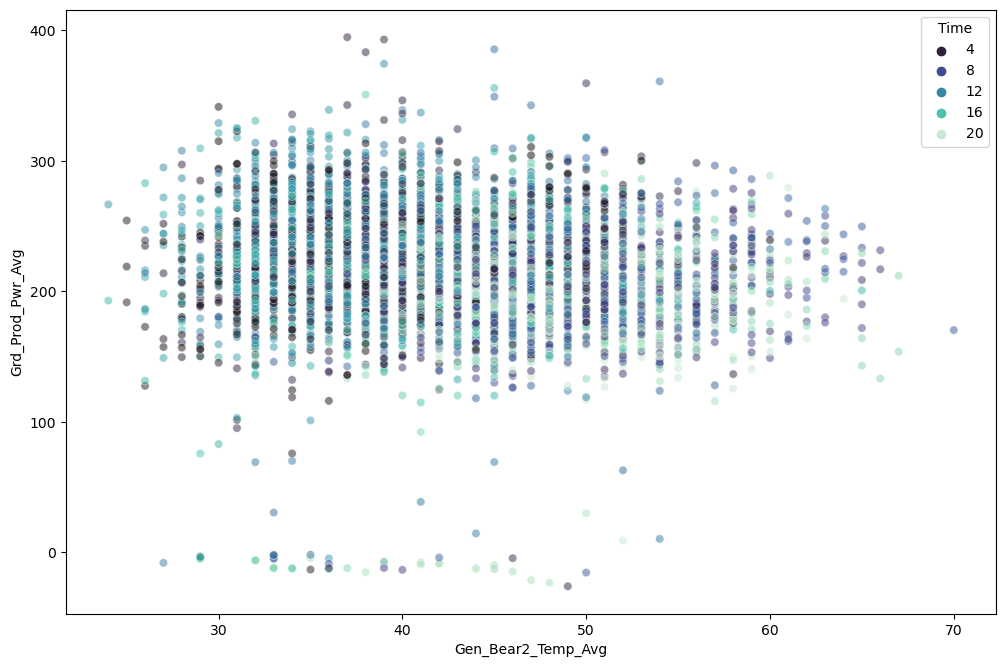

In [94]:
sns.scatterplot(data=windframe.sample(frac=1), x="Gen_Bear2_Temp_Avg", y="Grd_Prod_Pwr_Avg", hue="Time", alpha=0.5, palette="mako")

Ogólnie, cała temperatura wewnątrz komory turbiny zwiększa się wraz z czasem użytkowania generatora. Może być to wskaźnik zużycia turbiny.

<AxesSubplot:xlabel='Nac_Temp_Avg', ylabel='Grd_Prod_Pwr_Avg'>

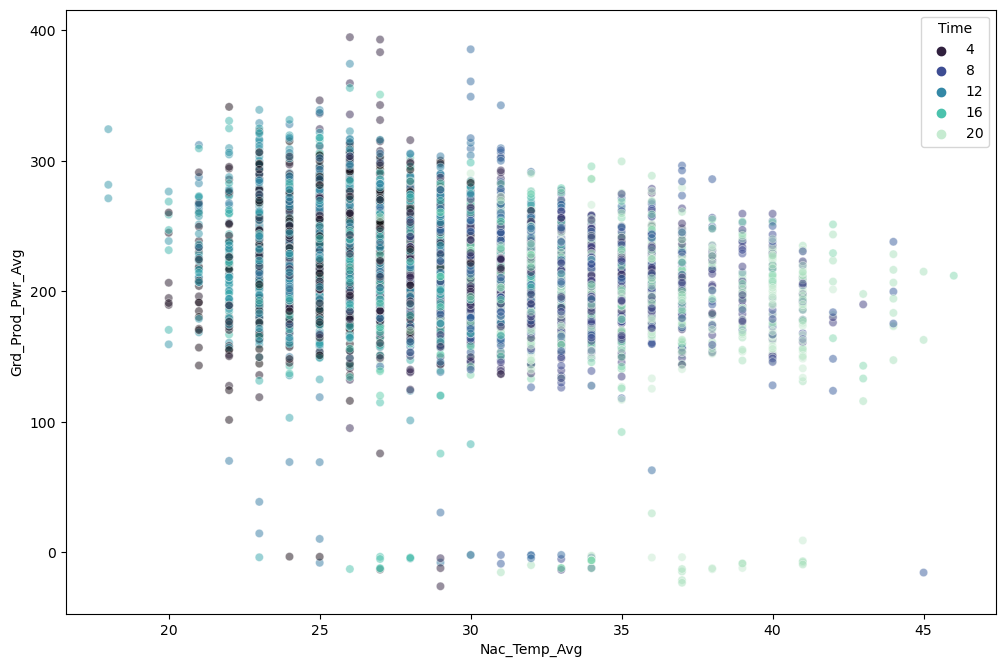

In [68]:
sns.scatterplot(data=windframe.sample(frac=1), x="Nac_Temp_Avg", y="Grd_Prod_Pwr_Avg", hue="Time", alpha=0.5, palette="mako")

### Wnioski z analizy temperatury turbiny
Możemy spróbować dopasować model regresji liniowej: `Grd_Prod_Pwr_Avg ~ Nac_Temp_Avg + Time` trzykrotnie, zamiast temperatury w niecce podstawiając tę na przekładni i generatorze. Współczynnik przy czasie powinien wyjść ujemy i obrazować, jak bardzo zużywa się turbina z każdym miesiącem.

In [82]:
model = LinearRegression().fit(windframe.loc[windframe.Time == 1, ["Nac_Temp_Avg"]], windframe.loc[windframe.Time == 1, 'Grd_Prod_Pwr_Avg'])

In [84]:
print(f"Intercept: {model.intercept_}\nNac_Temp_Avg: {model.coef_[0]}")

Intercept: 184.67387343998655
Nac_Temp_Avg: 1.816527766144568


In [87]:
print(model.score(windframe.loc[windframe.Time == 1, ["Nac_Temp_Avg"]], windframe.loc[windframe.Time == 1, 'Grd_Prod_Pwr_Avg']))

0.006131034791987955
